In [1]:
# Install required libraries
!pip install -q transformers torch torchaudio
!pip install -q openai-whisper
!pip install -q language-tool-python
!pip install -q spacy
!pip install -q sentence-transformers
!pip install -q lightgbm
!pip install -q pandas numpy scikit-learn
!pip install -q datasets
!pip install xgboost==1.7.6 scikit-learn==1.3.2
!pip install -q language-tool-python



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 76.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.3.2 requires numpy<2.0,>=1.17.3, but you have numpy 2.3.4 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.3.2 which is incompatible.
cuml-cu12 25.6.0 requires scikit-learn>=1.5, but you have scikit-learn 1.3.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.4 which is incompatible.
imbalanced-learn 0.14.0 requires scikit-learn<2,>=1.4.2, but you have scikit-learn 1.3.2 which is incompatible.
tensorflow 2.19.0 requires numpy<2

In [2]:
!apt-get update
!apt-get install -y openjdk-17-jre-headless


Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [3]:
# Download spaCy model
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 138.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
## 📦 Import Libraries

import os
import pandas as pd
import numpy as np
import torch
import torchaudio
import whisper
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')
# Grammar checking
import language_tool_python
# NLP processing
import spacy
from collections import Counter
# Embeddings
from sentence_transformers import SentenceTransformer

# ML models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# File_Path

In [3]:
# Define paths
TRAIN_AUDIO_PATH = "/content/drive/MyDrive/dataset/audios/train"
TEST_AUDIO_PATH = "/content/drive/MyDrive/dataset/audios/test"
TRAIN_CSV_PATH = "/content/drive/MyDrive/dataset/csvs/train.csv"
TEST_AUDIO_CSV="/content/drive/MyDrive/dataset/csvs/test.csv"

In [4]:
print(TEST_AUDIO_PATH)

/content/drive/MyDrive/dataset/audios/test


In [5]:
 #Load training data
train_df = pd.read_csv(TRAIN_CSV_PATH)
print(f"Training samples: {len(train_df)}")
print(train_df.head())

Training samples: 409
    filename  label
0  audio_173    3.0
1  audio_138    3.0
2  audio_127    2.0
3   audio_95    2.0
4   audio_73    3.5


In [6]:
# Load Whisper model
print("Loading Whisper model...")
device = "cuda" if torch.cuda.is_available() else "cpu"
whisper_model = whisper.load_model("large-v3", device=device)  # Use 'large-v3' for better accuracy
print(f"✅ Whisper model loaded on {device}")

Loading Whisper model...
✅ Whisper model loaded on cuda


# Whisper ASR Transcription

In [7]:
def transcribe_audio(audio_path):
    """Transcribe audio file to text using Whisper"""
    try:
        result = whisper_model.transcribe(
            audio_path,
            language="en",
            task="transcribe",
            fp16=(device == "cuda")
        )
        return result["text"].strip()
    except Exception as e:
        print(f"Error transcribing {audio_path}: {e}")
        return ""

In [ ]:
 #Transcribe all training audios
print("Transcribing training audios...")
transcripts = []

for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    audio_file = row['filename']
    audio_path = os.path.join(TRAIN_AUDIO_PATH, row["filename"] + ".wav")
  # Adjust column name
    if os.path.exists(audio_path):
        transcript = transcribe_audio(audio_path)
        transcripts.append(transcript)
    else:
        print(f"⚠️ Audio not found: {audio_path}")
        transcripts.append("")


In [ ]:
train_df['transcript'] = transcripts
# Save transcripts for future use
train_df.to_csv('/content/train_with_transcripts.csv', index=False)
print("✅ Transcription completed and saved")


In [9]:
train_df=pd.read_csv("/content/train_with_transcripts.csv")

In [10]:
train_df.head()

,filename,label,transcript
0,audio_173,3.0,My favorite place to visit would be Japan beca...
1,audio_138,3.0,I loved reading and my hobbies as reading. Emm...
2,audio_127,2.0,"Yeah, my favorite place to visit is Tirumala. ..."
3,audio_95,2.0,I am going to tell about my hobby and my hobby...
4,audio_73,3.5,"Hmm, this is a tough one. So, my best day of m..."


# Feature Extraction

In [11]:

### **2.1 Grammar Error Detection**
import language_tool_python

# Initialize LanguageTool (grammar checker)
print("Initializing grammar checker...")
tool = language_tool_python.LanguageTool('en-US')

def extract_grammar_features(text):
    """Extract grammar error features using LanguageTool"""
    if not text or len(text.strip()) == 0:
        return {
            'num_errors': 0,
            'error_density': 0,
            'spelling_errors': 0,
            'grammar_errors': 0,
            'style_errors': 0
        }

    matches = tool.check(text)

    # Count different error types
    error_types = Counter([m.ruleId for m in matches])
    spelling_errors = sum(1 for m in matches if 'SPELL' in m.ruleId or 'MORFOLOGIK' in m.ruleId)
    grammar_errors = sum(1 for m in matches if 'GRAMMAR' in m.ruleId or any(x in m.ruleId for x in ['VERB', 'AGREEMENT', 'TENSE']))
    style_errors = len(matches) - spelling_errors - grammar_errors

    word_count = len(text.split())

    return {
        'num_errors': len(matches),
        'error_density': len(matches) / word_count if word_count > 0 else 0,
        'spelling_errors': spelling_errors,
        'grammar_errors': grammar_errors,
        'style_errors': style_errors
    }

print("✅ Grammar checker initialized")



Initializing grammar checker...
✅ Grammar checker initialized


In [12]:

### **2.2 Linguistic Features (spaCy)**

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

def extract_linguistic_features(text):
    """Extract linguistic features using spaCy"""
    if not text or len(text.strip()) == 0:
        return {
            'word_count': 0,
            'sentence_count': 0,
            'avg_sentence_length': 0,
            'vocab_richness': 0,
            'noun_ratio': 0,
            'verb_ratio': 0,
            'adj_ratio': 0,
            'adv_ratio': 0,
            'avg_dep_depth': 0,
            'passive_voice_ratio': 0
        }

    doc = nlp(text)

    # Basic counts
    word_count = len([token for token in doc if not token.is_punct])
    sentences = list(doc.sents)
    sentence_count = len(sentences)

    # Sentence length
    avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0

    # Vocabulary richness (Type-Token Ratio)
    unique_words = len(set([token.lemma_.lower() for token in doc if token.is_alpha]))
    vocab_richness = unique_words / word_count if word_count > 0 else 0

    # POS tag distribution
    pos_counts = Counter([token.pos_ for token in doc])
    noun_ratio = pos_counts['NOUN'] / word_count if word_count > 0 else 0
    verb_ratio = pos_counts['VERB'] / word_count if word_count > 0 else 0
    adj_ratio = pos_counts['ADJ'] / word_count if word_count > 0 else 0
    adv_ratio = pos_counts['ADV'] / word_count if word_count > 0 else 0

    # Dependency parsing depth
    dep_depths = [len(list(token.ancestors)) for token in doc]
    avg_dep_depth = np.mean(dep_depths) if dep_depths else 0

    # Passive voice detection
    passive_count = sum(1 for token in doc if token.dep_ == 'nsubjpass')
    passive_voice_ratio = passive_count / sentence_count if sentence_count > 0 else 0

    return {
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_sentence_length': avg_sentence_length,
        'vocab_richness': vocab_richness,
        'noun_ratio': noun_ratio,
        'verb_ratio': verb_ratio,
        'adj_ratio': adj_ratio,
        'adv_ratio': adv_ratio,
        'avg_dep_depth': avg_dep_depth,
        'passive_voice_ratio': passive_voice_ratio
    }

print("✅ Linguistic feature extractor ready")


✅ Linguistic feature extractor ready


In [13]:

### **2.3 Semantic Embeddings (SBERT)**

# Load Sentence-BERT model
print("Loading Sentence-BERT model...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

def extract_embeddings(text):
    """Extract semantic embeddings using Sentence-BERT"""
    if not text or len(text.strip()) == 0:
        return np.zeros(384)  # all-MiniLM-L6-v2 produces 384-dim embeddings

    embedding = sbert_model.encode(text, convert_to_numpy=True)
    return embedding

print("✅ Sentence-BERT model loaded")

Loading Sentence-BERT model...
✅ Sentence-BERT model loaded


In [14]:
### **2.4 Combined Feature Extraction**
def extract_all_features(text):
    """Extract all features from transcript"""
    # Grammar features
    grammar_feats = extract_grammar_features(text)

    # Linguistic features
    linguistic_feats = extract_linguistic_features(text)

    # Semantic embeddings
    embeddings = extract_embeddings(text)

    # Combine all features
    all_features = {**grammar_feats, **linguistic_feats}

    return all_features, embeddings

In [15]:

# Extract features for all training samples
print("Extracting features from transcripts...")
feature_list = []
embeddings_list = []

for transcript in tqdm(train_df['transcript']):
    features, embeddings = extract_all_features(transcript)
    feature_list.append(features)
    embeddings_list.append(embeddings)


Extracting features from transcripts...


  0%|          | 0/409 [00:00<?, ?it/s]

In [16]:
len(feature_list)

409

In [17]:
# Convert to DataFrame
features_df = pd.DataFrame(feature_list)
embeddings_array = np.vstack(embeddings_list)

print(f"✅ Feature extraction completed")
print(f"   Structured features shape: {features_df.shape}")
print(f"   Embeddings shape: {embeddings_array.shape}")


✅ Feature extraction completed
   Structured features shape: (409, 15)
   Embeddings shape: (409, 384)


In [18]:
print(features_df.head(1))
type(features_df)

   num_errors  error_density  spelling_errors  grammar_errors  style_errors  \
0          12       0.083333                1               0            11   

   word_count  sentence_count  avg_sentence_length  vocab_richness  \
0         149               9            16.555556        0.355705   

   noun_ratio  verb_ratio  adj_ratio  adv_ratio  avg_dep_depth  \
0     0.14094    0.147651   0.087248   0.053691       4.778523   

   passive_voice_ratio  
0                  0.0  


pandas.core.frame.DataFrame

In [19]:
train_df.columns

Index(['filename', 'label', 'transcript'], dtype='object')

 **Scaling & Train/Val Split**

In [20]:
## 🤖 Stage 3: Model Training

### **3.1 Prepare Training Data**

# Combine structured features and embeddings
X_structured = features_df.values
X_embeddings = embeddings_array
X_combined = np.hstack([X_structured, X_embeddings])

# Target variable (grammar score)
y = train_df['label'].values # Adjust column name

In [21]:
X_combined

array([[ 1.20000000e+01,  8.33333333e-02,  1.00000000e+00, ...,
         3.97269167e-02, -9.35416892e-02,  4.56085865e-04],
       [ 2.00000000e+00,  1.25000000e-02,  2.00000000e+00, ...,
         3.43121588e-02, -7.24738985e-02, -4.82080169e-02],
       [ 5.00000000e+00,  8.06451613e-02,  5.00000000e+00, ...,
         6.86959550e-02, -5.95027208e-02, -2.57488713e-03],
       ...,
       [ 2.00000000e+00,  2.12765957e-02,  0.00000000e+00, ...,
         7.32543692e-02, -1.25321940e-01, -4.72458638e-02],
       [ 7.00000000e+00,  4.21686747e-02,  2.00000000e+00, ...,
         4.92534749e-02, -6.26998246e-02, -1.69970896e-02],
       [ 2.00000000e+00,  1.86915888e-02,  0.00000000e+00, ...,
        -2.27932502e-02, -1.60231829e-01,  6.02728203e-02]])

In [22]:
y[0:3]

array([3., 3., 2.])

In [23]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)


In [24]:
import numpy as np
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
# print("Means:", scaler.mean_)       # Mean for each feature
# print("Std devs:", scaler.scale_)
print(X_train_scaled.shape)

Training set: (327, 399)
Validation set: (82, 399)
(327, 399)


In [ ]:
len(X_train_scaled)
len(y_train)

327

In [ ]:
len(y_train)

327

In [ ]:
len(train_df)

409

**ML Model Training**

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import time

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'min_child_weight': [1, 3, 5]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(tree_method="gpu_hist", verbosity=2),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=5
)

start_time = time.time()
grid_search.fit(X_train_scaled, y_train)
end_time = time.time()

print('Best params:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)
print('Total training time (seconds):', end_time - start_time)


Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, subsample=0.8;, score=-1.142 total time=   0.6s
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, subsample=0.8;, score=-1.139 total time=   0.3s
[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, subsample=0.8;, score=-1.110 total time=   0.3s
[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, subsample=1.0;, score=-1.153 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, subsample=1.0;, score=-1.143 total time=   0.3s
[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=4, min_child_weight=1, subsample=1.0;, score=-1.097 total time=   0.3s
[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max

In [ ]:
best_model = grid_search.best_estimator_


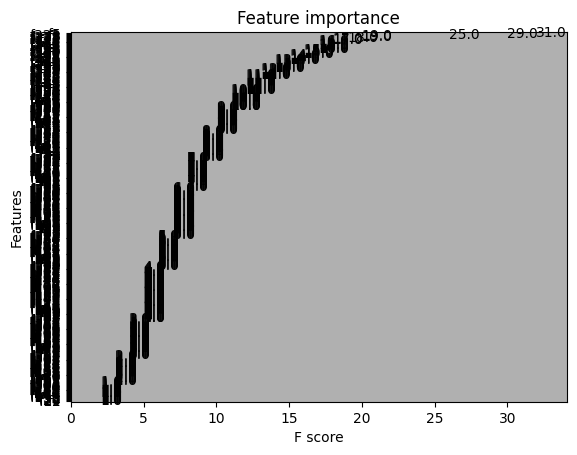

In [ ]:
import matplotlib.pyplot as plt

# Get the underlying Booster object
booster = grid_search.best_estimator_.get_booster()

# Plot feature importance using Booster
xgb.plot_importance(booster)
plt.show()


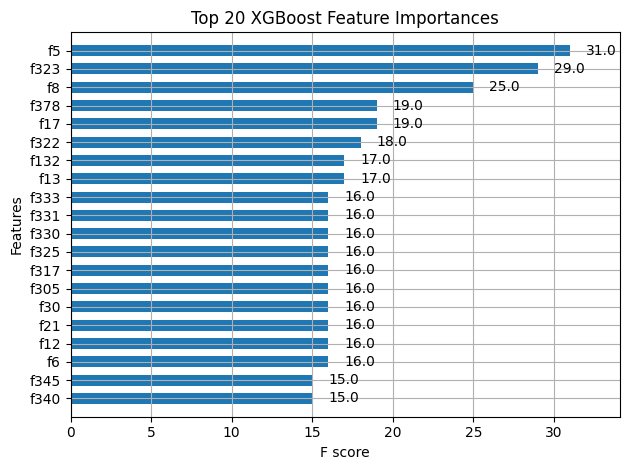

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

# For XGBoost, get the Booster object from best estimator:
booster = grid_search.best_estimator_.get_booster()

# Plot only top 20 features, set figure size for clarity
xgb.plot_importance(booster, max_num_features=20, height=0.6)
plt.title("Top 20 XGBoost Feature Importances")
plt.tight_layout()
plt.show()


In [ ]:
print(best_model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


In [25]:
import joblib
#joblib.dump(best_model, "best_xgboost_sklearn.pkl")
# Later:
best_model = joblib.load("best_xgboost_sklearn.pkl")

In [44]:
# Predict on the validation set
y_pred_xgb = best_model.predict(X_val_scaled)

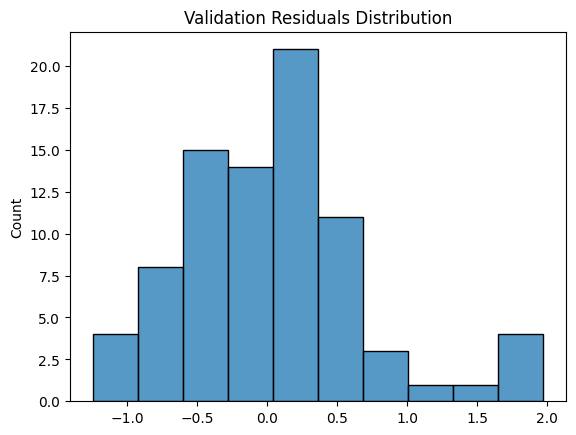

In [28]:
import seaborn as sns
residuals = y_val - y_pred_xgb
sns.histplot(residuals)
plt.title("Validation Residuals Distribution")
plt.show()


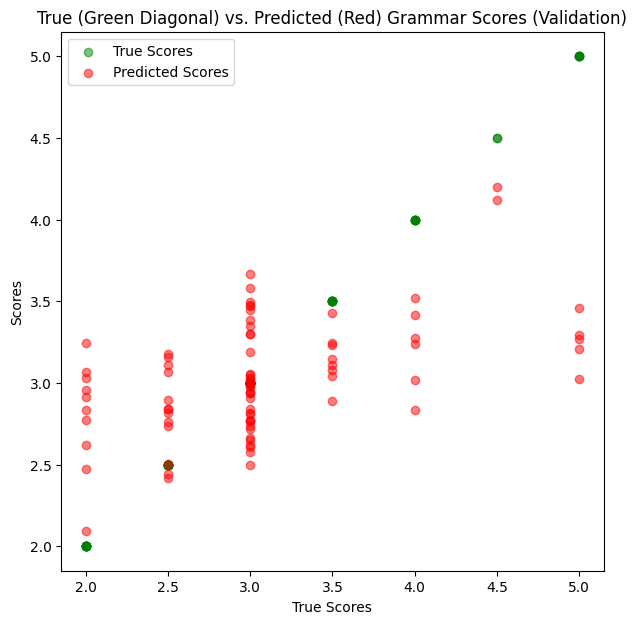

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))

# True scores (as diagonal, ideal predictions)
plt.scatter(y_val, y_val, color='green', alpha=0.5, label='True Scores')

# Predicted scores (actual model predictions)
plt.scatter(y_val, y_pred_xgb, color='red', alpha=0.5, label='Predicted Scores')

plt.xlabel("True Scores")
plt.ylabel("Scores")
plt.title("True (Green Diagonal) vs. Predicted (Red) Grammar Scores (Validation)")
plt.legend()
plt.show()




# Xgboost RMSE

In [29]:
# Compare predictions to actual y_val labels
from sklearn.metrics import mean_squared_error
import numpy as np

val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
print('Validation RMSE:', val_rmse)

Validation RMSE: 0.6436660954176985


In [ ]:
print(y_val.min(), y_val.max(), y_val.mean(), y_val.std())


2.0 5.0 3.0792682926829267 0.7427269801504632


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
baseline_rmse = np.sqrt(mean_squared_error(y_val, [y_train.mean()] * len(y_val)))
print('Baseline RMSE:', baseline_rmse)


Baseline RMSE: 0.7720531041935437


In [ ]:
#traininglightGBM model
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import time

# Parameter grid for LightGBM
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'num_leaves': [31, 63],
    'min_child_samples': [10, 20],
    'reg_alpha': [0.0, 0.1],
    'reg_lambda': [0.0, 1.0]
}

# Make sure LightGBM is set for GPU
lgb_estimator = lgb.LGBMRegressor(
    n_estimators=200,
    random_state=42,
    device='gpu',       # Train on GPU
    verbosity=2
)

# Grid Search setup
grid_search_1= GridSearchCV(
    estimator=lgb_estimator,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=5
)

# Timing the full operation
start_time = time.time()
grid_search_1.fit(X_train_scaled, y_train)
end_time = time.time()

# Printing results
print('Best params:', grid_search_1.best_params_)
print('Best score:', grid_search_1.best_score_)
print('Total training time (seconds):', end_time - start_time)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 9 and depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 5
[LightGBM] [Warning] No further splits with positiv

In [ ]:
best_model_1 = grid_search_1.best_estimator_

In [ ]:
best_model_1

LGBMRegressor(colsample_bytree=0.8, device='gpu', max_depth=4, n_estimators=200,
              num_leaves=63, random_state=42, subsample=0.8, verbosity=2)

In [26]:
import joblib
#joblib.dump(best_model_1, "best_lgbm_sklearn.pkl")
# Later:
best_model_1 = joblib.load("best_lgbm_sklearn.pkl")


In [45]:
# Predict on the validation set
y_pred_lgb = best_model_1.predict(X_val_scaled)

In [ ]:
y_pred_lgb[:3]

array([3.04621804, 2.98151682, 3.36659182])

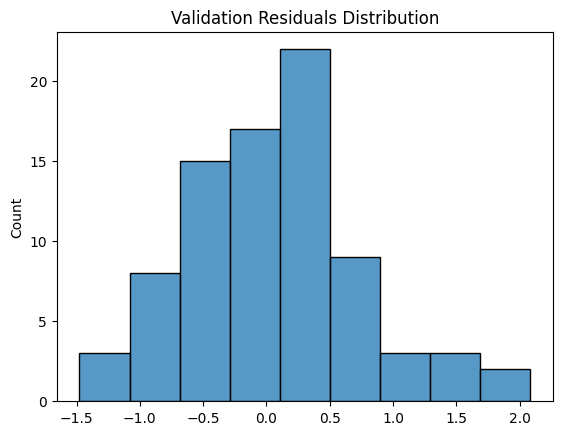

In [32]:
import seaborn as sns
residuals = y_val - y_pred_lgb
sns.histplot(residuals)
plt.title("Validation Residuals Distribution")
plt.show()


# Lightlgbm RMSE

In [33]:
# Compare predictions to actual y_val labels
from sklearn.metrics import mean_squared_error
import numpy as np

val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_lgb))
print('Validation RMSE:', val_rmse)

Validation RMSE: 0.6967504916750838


In [ ]:
print(y_val.min(), y_val.max(), y_val.mean(), y_val.std())


2.0 5.0 3.0792682926829267 0.7427269801504632


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
baseline_rmse = np.sqrt(mean_squared_error(y_val, [y_train.mean()] * len(y_val)))
print('Baseline RMSE:', baseline_rmse)


Baseline RMSE: 0.7720531041935437


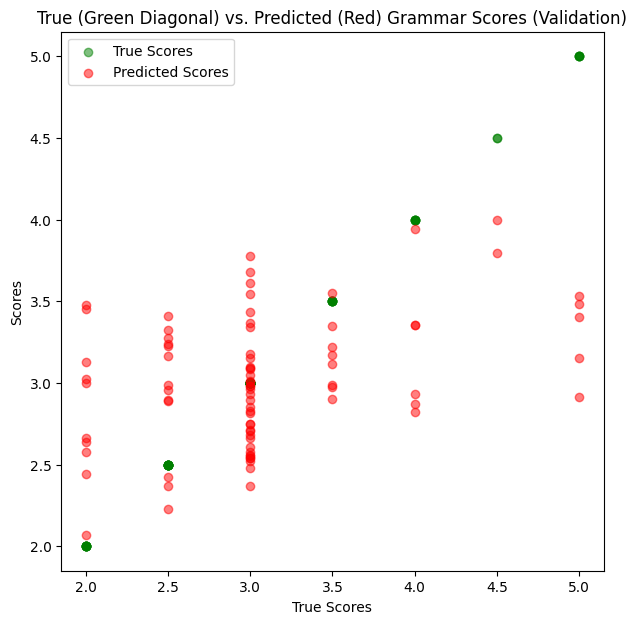

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))

# True scores (as diagonal, ideal predictions)
plt.scatter(y_val, y_val, color='green', alpha=0.5, label='True Scores')

# Predicted scores (actual model predictions)
plt.scatter(y_val, y_pred_lgb, color='red', alpha=0.5, label='Predicted Scores')

plt.xlabel("True Scores")
plt.ylabel("Scores")
plt.title("True (Green Diagonal) vs. Predicted (Red) Grammar Scores (Validation)")
plt.legend()
plt.show()


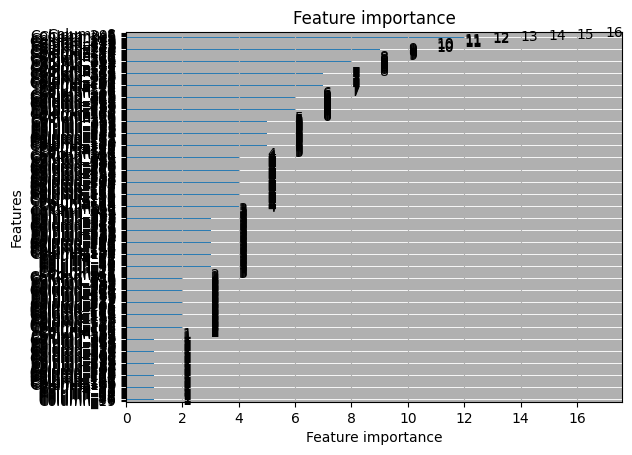

In [ ]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# For LightGBM
lgb.plot_importance(grid_search_1.best_estimator_.booster_)
plt.show()


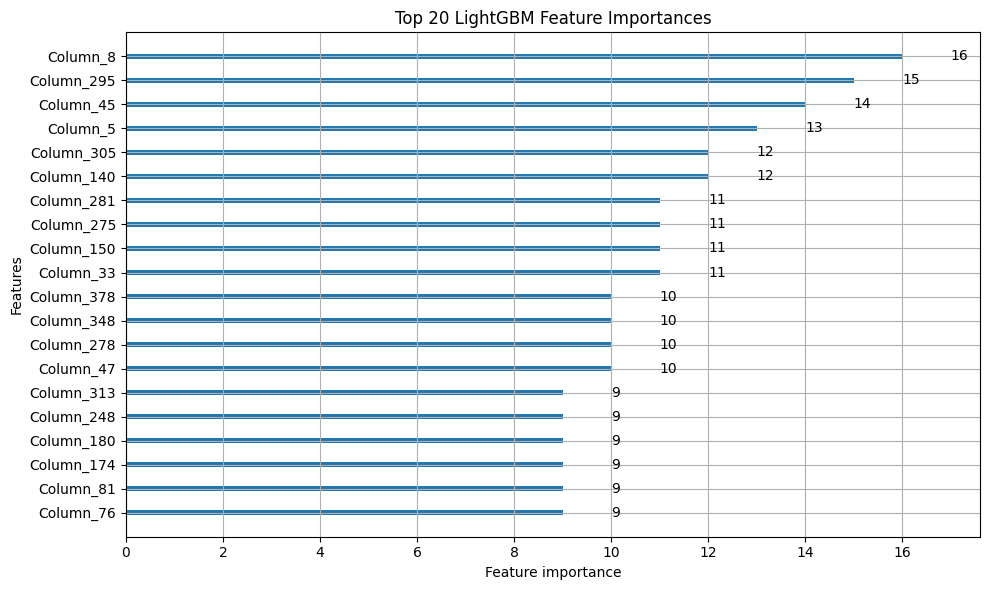

In [ ]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# This plots only the top 20 important features
lgb.plot_importance(grid_search_1.best_estimator_.booster_, max_num_features=20, figsize=(10, 6))
plt.title("Top 20 LightGBM Feature Importances")
plt.tight_layout()
plt.show()


****

# Ensemble RMSE

In [34]:
#  y_pred_xgb and y_pred_lgbm are both predictions on the same validation/test set
y_pred_ensemble = (y_pred_xgb + y_pred_lgb) / 2

# Evaluate
from sklearn.metrics import mean_squared_error
ensemble_rmse = np.sqrt(mean_squared_error(y_val, y_pred_ensemble))
print("Ensemble RMSE:", ensemble_rmse)


Ensemble RMSE: 0.6611808643401333


# Stack Ensemble

In [46]:
from sklearn.linear_model import RidgeCV
ridge_model = RidgeCV()
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_val_scaled)



## Stack Ensemble RMSE

In [36]:
import numpy as np

# Meta-features: columns are predictions from your base models
meta_X = np.column_stack([y_pred_xgb, y_pred_lgb, y_pred_ridge])

# Train meta-model (can use RidgeCV or LinearRegression)
meta_model = RidgeCV()
meta_model.fit(meta_X, y_val)

# Meta-model outputs ensemble predictions
y_pred_stack = meta_model.predict(meta_X)

# Evaluate stacking ensemble RMSE
from sklearn.metrics import mean_squared_error
stack_rmse = np.sqrt(mean_squared_error(y_val, y_pred_stack))
print("Stacking Ensemble RMSE:", stack_rmse)


Stacking Ensemble RMSE: 0.6258483538101282


# Evaluation

In [37]:

## 📊 Stage 4: Evaluation


# Predictions

# Meta-features: columns are predictions from your base models
meta_X = np.column_stack([y_pred_xgb, y_pred_lgb, y_pred_ridge])

# Train meta-model (can use RidgeCV or LinearRegression)
meta_model = RidgeCV()
meta_model.fit(meta_X, y_val)

# Meta-model outputs ensemble predictions
y_pred_stack = meta_model.predict(meta_X)
y_pred_xgb = best_model.predict(X_val_scaled)
y_pred_lgb = best_model_1.predict(X_val_scaled)

# Ensemble (average of both models)
y_pred_ensemble = (y_pred_xgb + y_pred_lgb) / 2

def evaluate_model(y_true, y_pred, model_name):
    """Calculate evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{'='*50}")
    print(f"{model_name} Performance")
    print(f"{'='*50}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")

    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Evaluate all models
metrics_xgb = evaluate_model(y_val, y_pred_xgb, "XGBoost")
metrics_lgb = evaluate_model(y_val, y_pred_lgb, "LightGBM")
metrics_ensemble = evaluate_model(y_val, y_pred_ensemble, "Ensemble")
metrics_stackensemble=evaluate_model(y_val, y_pred_stack, "Stack Ensemble")

#



XGBoost Performance
RMSE: 0.6437
MAE:  0.4734
R²:   0.2490

LightGBM Performance
RMSE: 0.6968
MAE:  0.5339
R²:   0.1200

Ensemble Performance
RMSE: 0.6612
MAE:  0.5001
R²:   0.2075

Stack Ensemble Performance
RMSE: 0.6258
MAE:  0.4680
R²:   0.2900


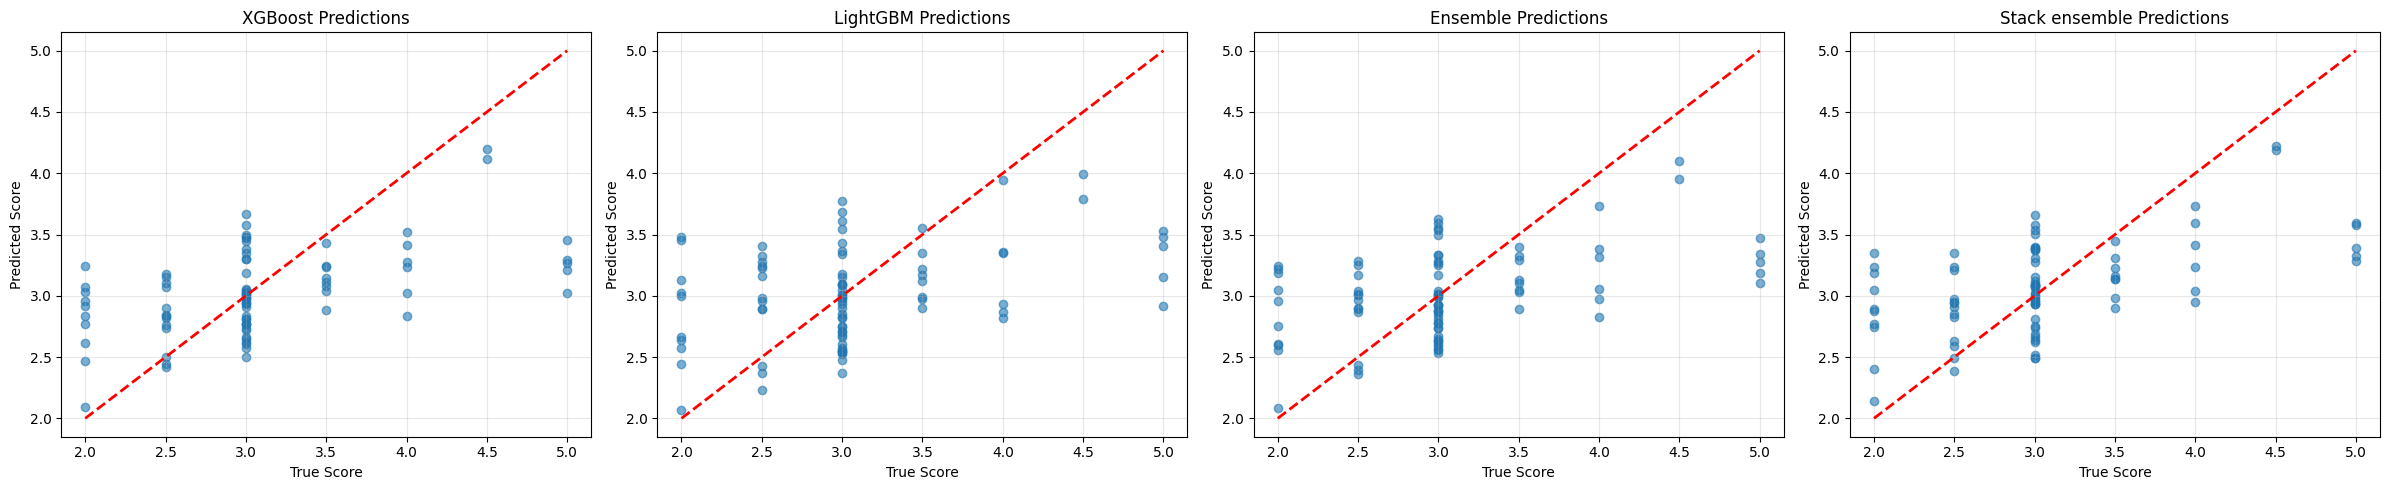

In [38]:

# Visualization
fig, axes = plt.subplots(1, 4, figsize=(24, 5)) # Changed 1, 3 to 1, 4 to accommodate all 4 plots

for idx, (y_pred, title) in enumerate([
    (y_pred_xgb, 'XGBoost'),
    (y_pred_lgb, 'LightGBM'),
    (y_pred_ensemble, 'Ensemble'),
    (y_pred_stack,"Stack ensemble")
]):
    axes[idx].scatter(y_val, y_pred, alpha=0.6)
    axes[idx].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
    axes[idx].set_xlabel('True Score')
    axes[idx].set_ylabel('Predicted Score')
    axes[idx].set_title(f'{title} Predictions')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Inference on Test Set

In [29]:
test_df=pd.read_csv("/content/drive/MyDrive/dataset/csvs/test.csv")

In [30]:
TRAIN_AUDIO_PATH="/content/drive/MyDrive/dataset/audios/test"

In [ ]:
 #Transcribe all training audios
print("Transcribing testing audios...")
test_transcripts = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    audio_file = row['filename']
    audio_path = os.path.join(TRAIN_AUDIO_PATH, row["filename"] + ".wav")
  # Adjust column name
    if os.path.exists(audio_path):
        transcript = transcribe_audio(audio_path)
        test_transcripts.append(transcript)
    else:
        print(f"⚠️ Audio not found: {audio_path}")
        transcripts.append("")


In [ ]:
test_df["transcripts"]=test_transcripts

In [31]:
test_df=pd.read_csv("/content/test_with_transcripts.csv")

In [32]:
test_df.head()

,filename,transcript
0,audio_141,I love I love when I love stories Sherlock Hol...
1,audio_114,I have a lot of favorite days but one of the b...
2,audio_17,My topic is describe the scene of a hospital. ...
3,audio_76,A playground has a lot of equipment. It typica...
4,audio_156,The best day of my life are the most days when...


In [33]:
test_df.shape

(197, 2)

In [34]:
test_df['transcript']


,transcript
0,I love I love when I love stories Sherlock Hol...
1,I have a lot of favorite days but one of the b...
2,My topic is describe the scene of a hospital. ...
3,A playground has a lot of equipment. It typica...
4,The best day of my life are the most days when...
...,...
192,This goal is important to me because initially...
193,The market is crowded. There are a lot of peop...
194,"My favorite place to visit is a warm, sunny be..."
195,"Hi, my best friend, his name is Rajeev and he ..."


In [35]:
# Extract features from test transcripts
print("Extracting features from test transcripts...")
test_feature_list = []
test_embeddings_list = []

for transcript in tqdm(test_df['transcript']):
    features_1, embeddings_1 = extract_all_features(transcript)
    test_feature_list.append(features_1)
    test_embeddings_list.append(embeddings_1)


Extracting features from test transcripts...


  0%|          | 0/197 [00:00<?, ?it/s]

In [36]:
# Prepare test data
test_features_df = pd.DataFrame(test_feature_list)
test_embeddings_array = np.vstack(test_embeddings_list)
X_test = np.hstack([test_features_df.values, test_embeddings_array])
X_test_scaled = scaler.transform(X_test)

# Prediction

In [47]:
# meta ridge prediction
test_pred_ridge = ridge_model.predict(X_test_scaled)
#xgboost-model prediction
test_pred_xgb = best_model.predict(X_test_scaled)
#LightLGBM - model preediction
test_pred_lgb = best_model_1.predict(X_test_scaled)

# Prepare meta-features for training the meta-model using validation set predictions
meta_X_val = np.column_stack([y_pred_xgb, y_pred_lgb, y_pred_ridge])

# Train meta-model on validation set predictions and true validation labels
meta_model = RidgeCV()
meta_model.fit(meta_X_val, y_val)

# Prepare meta-features for prediction on the test set using test set predictions
meta_X_test = np.column_stack([test_pred_xgb, test_pred_lgb, test_pred_ridge])

# Meta-model outputs ensemble predictions for the test set
test_pred_stack = meta_model.predict(meta_X_test)

# Ensemble (average of both models) for the test set
test_pred_ensemble = (test_pred_xgb + test_pred_lgb) / 2

In [48]:
import pandas as pd

# Load test.csv to get filenames
test_df = pd.read_csv("/content/drive/MyDrive/dataset/csvs/test.csv")
# since the best model here is stcking ensemble so , for infrencing we are choosing that
# If you want only filename and prediction:
submission = pd.DataFrame({
    "filename": test_df["filename"],
    "prediction": test_pred_stack
})

# Save final CSV
submission.to_csv("submission.csv", index=False)
